<a href="https://colab.research.google.com/github/sgr1118/GD-NLP/blob/main/%5BGD_08%5D_Translate_with_Seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 8-7. 프로젝트: 한영 번역기 만들기

# Step 1. 데이터 다운로드

아래 링크에서 korean-english-park.train.tar.gz 를 다운로드받아 한영 병렬 데이터를 확보합니다.

[jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 사전 준비 - 한글 폰트 설치하기
# 설치 후 런타임 다시 시작 필수

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [3]:
# 필요한 라이브러리 불러오기

import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

In [4]:
# 경로 지정
%cd /content/drive/MyDrive/Aiffel/GD_project/GD8_file

# 데이터 다운로드
!wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz

# 데이터 압축 해제
!tar -xzvf korean-english-park.train.tar.gz

/content/drive/MyDrive/Aiffel/GD_project/GD8_file
--2022-10-09 09:51:28--  https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz [following]
--2022-10-09 09:51:29--  https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8718893 (8.3M) [application/octet-stream]
Sav

In [5]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2022-10-09 09:51:33--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-10-09 09:51:33--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4a0caea7e5699e6e4dacffebac.dl.dropboxusercontent.com/cd/0/get/BueL5Czx6f7f9aJDCEFHQuYI7dZx6J0Oc8zgyL8ZNd6mpXxPf4xxybdxZe-4xqzIs7nHMLFPzB6xe8bDaY7yG8byJmZLwR9bYTHTi-TSKXhTDWiBx4trC8ZgNedqy-oplvlVeRxcVTaFtk9ixwazFMZUz_Vxc5VeSXembDXvjVRjDnOHYJ0s0Nx-k5hr8nzvpxo/file?dl=1# [following]
--2022-10-09 09:51:34--  https://uc4a0caea7e5699e6e4dacffebac.dl.dropboxusercontent.com/cd/0/get/BueL5Czx6

In [6]:
# 데이터 불러오기
kor_path = '/content/drive/MyDrive/Aiffel/GD_project/GD8_file/korean-english-park.train.ko'
eng_path = '/content/drive/MyDrive/Aiffel/GD_project/GD8_file/korean-english-park.train.en'

def load_file(file_path):
  with open(file_path, 'r') as f:
    raw = f.read().splitlines()

  print('Data size:', len(raw))
  print('Example:')

  for sen in raw[0:100][::20]:print('>>', sen)
  
  return raw

In [7]:
# kor, eng 지정후 데이터 출력

kor = load_file(kor_path)
eng = load_file(eng_path)
print(type(kor_path), type(eng_path))

# kor data_size, eng data_size는 94123개이다.
# type은 class 'str'이다.

Data size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.
Data size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give th

# Step 2. 데이터 정제

1. set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.
- 2가지 데이터 셋을 하나로 만들어서 중복을 제거하고 cleaned_corpus에 저장하자

2. 앞서 정의한 preprocessing() 함수는 한글에서는 동작하지 않습니다. 한글에 적용할 수 있는 정규식을 추가하여 함수를 재정의하세요!

3. 타겟 언어인 영문엔 <start> 토큰과 <end> 토큰을 추가하고 split() 함수를 이용하여 토큰화합니다. 한글 토큰화는 KoNLPy의 mecab 클래스를 사용합니다.

모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다. cleaned_corpus로부터 토큰의 길이가 40 이하인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축하세요.

2-1. 중복된 데이터 삭제
- zip을 사용하여 dataset을 합친 후  set을 사용하여 중복된 데이터를 삭제하여 병렬 쌍을 유지한다.

[python-zip설명](https://ooyoung.tistory.com/60)

[python-set설명](https://wikidocs.net/16044)

발생한 오류

'zip argument #1 must support iteration'
- tuple의 원소는 list가 아닌 하나의 값을 가지기 때문에 zip을 적용할 수 없었기 때문에 load_file 함수에서 return raw를하여 문제를 해결하였다.

In [8]:
# data set 합치기 - zip 사용
data_set = zip(kor, eng)
data_set

# row_set을 사용하여 중복제거
row_set = set(data_set)

# 데이터 길이 확인
len(row_set)

78968

In [9]:
# cleaned_corpus에 데이터 저장

cleaned_corpus_kor, cleaned_corpus_eng = zip(*row_set)
# 이 리스트 앞에 풀기(unpacking) 연산자 붙여서 다시 zip() 함수에 넘기면 다시 원래의 2개의 터플을 얻을 수 있습니다.

In [10]:
# cleaned_corpus len 확인

print('kor_data_size_len:', len(cleaned_corpus_kor))
print('eng_data_size_len:', len(cleaned_corpus_eng))

# 병렬 데이터인것을 확인하고 

kor_data_size_len: 78968
eng_data_size_len: 78968


2-2. 정규식을 사용하여 preprocessing 함수 구현
- 한글 데이터에 맞는 정규표현식 사용
- 40이하의 corpus만 append하기

In [11]:
# cleaned_corpus_kor random 추출
import random

random.sample(cleaned_corpus_kor, 15)

['민주당 힐러리 클린턴 후보와 배럭 오바마 후보가 최대 규모의 대선 예비 선거를 이틀 앞두고 지금 까지 거의 백중세를 기록하고 있다.',
 '미 공군은 지난 27년 동안 레이더를 피할 수 있는 제 1세대 스텔스 전투기 F-117을 세르비아에서 이라크까지 적의 영공을 순찰하는데 사용했다. 이 전투기 다음달 네바다에서 퇴역한다.',
 '한편 한국 관계자와 탈레반 지도자는 7일(현지시각) 빠른 시일내 한국인 인질 석방 협상을 하기로 합의했다.',
 '그는 5일 후 정상적인 식사를 하고 퇴원했다.',
 '아르센 웽거 아스날 감독은 “전체적으로 경기 내용이 좋았다”며 “승리할 수 있는 기회를 놓친 것이 아쉽다”고 전했다.',
 '올해 72세인 영화계 백전 노장 애킨이 아카데미상을 수상하기는 이번이 처음이다.',
 '유저들의 클릭 한번으로 유명해 질 수 도 있으며 어둠 속에서 사라지게 될 수도 있다.',
 '그들은 20만명에 이르는 종군 위안부에게 일어났던 모든 일에 대해 일본의 사과를 요구할 예정이다.',
 '허드슨 측 홍보 담당자는 성명에서 허드슨과 그의 가족은 조카의 무사귀환을 위해 현상금 10만달러(약 1억4000만원)를 걸었다고 밝혔다.',
 '두자니는 파키스탄에서 학문을 익혔으며 1988년부터 1991년까지 아프가니스탄에서 전사로 활약했다.',
 '오늘 두 대의 헬리콥터가 이라크 북부 상공에서 충돌하여 미군 네 명이 사망했다고 미군 당국이 발표했습니다.',
 "'더 아트 오브 더 브릭(The Art of the Brick)'이라는 사와야의 미국내 순회 전시회가 열리고있다.",
 '그러나 니콜라 사르코지 프랑스 대통령의 개입으로 그들은 프랑스로 송환됐다.',
 '발렌티는“식당에서 12년간 근무했지만 여태 본 바다가재 중에 조지가 가장 크다”고 말했다.',
 '러시아가 더이상 유지관리할 여력이 없는 이 미르 호를 어떻게 할것이냐에 대해 관리들은 여러달 동안 논쟁을 벌여왔다.']

In [12]:
# preprocessing 함수 구현

def preprocessing_sentence(sentence, s_token=False, e_token=False):
  sentence = sentence.lower().strip()

  sentence = re.sub(r'([?.!,])', r' \1', sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  sentence = re.sub(r"[^a-zA-Z?.!,ㄱ-ㅎ가-힣ㅏ-ㅣ0-9]+", " ", sentence)

  sentence = sentence.strip()

  if s_token:
    sentence = '<start> ' + sentence

  if e_token:
    sentence += ' <end>'

  return sentence

In [13]:
enc_corpus = []
dec_corpus = []

for kor, eng in zip(cleaned_corpus_kor, cleaned_corpus_eng):
  kor_ = preprocessing_sentence(kor)
  eng_ = preprocessing_sentence(eng, s_token=True, e_token=True)

  if len(kor_) <= 40:
    enc_corpus.append(kor_)
    dec_corpus.append(eng_)

In [14]:
# 처리 결과 확인하기
print('enc_corpus len:',len(enc_corpus), 'dec_corpus len:',len(dec_corpus))

print(enc_corpus[100])
print(dec_corpus[100])

enc_corpus len: 15178 dec_corpus len: 15178
이들은 지난 9월 이후로 신문에 대운하 반대 광고를 게시하고 있다 .
<start> they have been running anti canal ads in newspapers since september . <end>


# Step 3. 데이터 토큰화

앞서 정의한 tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 얻으세요! 단어의 수는 실험을 통해 적당한 값을 맞춰주도록 합니다! (최소 10,000 이상!)

❗ 주의: 난이도에 비해 데이터가 많지 않아 훈련 데이터와 검증 데이터를 따로 나누지는 않습니다.


In [15]:
# mecab 불러오기

from konlpy.tag import Mecab

In [72]:
# tokenize 함수 작성
vocab_size = 30000

def tokenize(corpus, kor = False, eng = True):
  if kor :
    mecab = Mecab()
    morph = [' '.join(mecab.morphs(sentence)) for sentence in corpus]
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', num_words = vocab_size)
    tokenizer.fit_on_texts(morph)
    tensor = tokenizer.texts_to_sequences(morph)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding = 'post')

  if eng :
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', num_words=vocab_size)
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding = 'post')

  return tensor, tokenizer

In [73]:
# 토큰화하기
enc_train, enc_tokenizer = tokenize(enc_corpus, kor = True)
dec_train, dec_tokenizer = tokenize(dec_corpus, eng = True)

print("English Vocab Size:", len(enc_tokenizer.index_word))
print("Spanish Vocab Size:", len(dec_tokenizer.index_word))

English Vocab Size: 39682
Spanish Vocab Size: 16894


# Step 4. 모델 설계

한국어를 영어로 잘 번역해 줄 멋진 Attention 기반 Seq2seq 모델을 설계하세요! 앞서 만든 모델에 Dropout 모듈을 추가하면 성능이 더 좋아집니다! Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞춰 주도록 합니다!

In [63]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.w_dec = tf.keras.layers.Dense(units)
    self.w_enc = tf.keras.layers.Dense(units)
    self.w_com = tf.keras.layers.Dense(1)

  def call(self,h_enc, h_dec):
    # h_enc shape: [batch x length x units]
    # h_dec shape: [batch x units]

    h_enc = self.w_enc(h_enc)
    h_dec = tf.expand_dims(h_dec, 1)
    h_dec = self.w_dec(h_dec)

    score = self.w_com(tf.nn.tanh(h_dec + h_enc))

    attn = tf.nn.softmax(score, axis=1)

    context_vec = attn * h_enc
    context_vec = tf.reduce_sum(context_vec, axis=1)

    return context_vec, attn

In [64]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()

    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True)

  def call(self, x):
    out = self.embedding(x)
    out = self.gru(out)

    return out

In [65]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(dec_units, return_sequences=True,
                                   return_state=True)
    self.fc = tf.keras.layers.Dense(vocab_size)
    
    self.attention = BahdanauAttention(self.dec_units)   # Attention 필수 사용!

  def call(self, x, h_dec, enc_out):
    context_vec, attn = self.attention(enc_out, h_dec)

    out = self.embedding(x)
    out = tf.concat([tf.expand_dims(context_vec, 1), out], axis = -1)

    out, h_dec = self.gru(out)
    out = tf.reshape(out, (-1, out.shape[2]))
    out = self.fc(out)

    return out, h_dec, attn

In [75]:
#실행하여 결과 확인해보기

BATCH_SIZE = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
# 
sample_output = encoder(sample_enc)

print('Encoder Output : ', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output :  (64, 30, 1024)
Decoder Output: (64, 16895)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


# Step 5. 훈련하기

훈련엔 위에서 사용한 코드를 그대로 사용하되, eval_step() 부분이 없음에 유의합니다! 매 스텝 아래의 예문에 대한 번역을 생성하여 본인이 생각하기에 가장 멋지게 번역한 Case를 제출하세요! (Attention Map을 시각화해보는 것도 재밌을 거예요!)

![](https://d3s0tskafalll9.cloudfront.net/media/images/GN-4-P-4.max-800x600.jpg)
<center>attention map 예시</center>


In [67]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss = loss_object(real, pred)

  mask = tf.cast(mask, dtype = loss.dtype)
  loss *= mask # *=는 왼쪽 변수에 오른쪽 값을 곱하고 그 결과를 왼쪽 변수에 할당한다.
  # 예시로 a *= b는 a = a*b를 의미함.

  return tf.reduce_mean(loss)

# 8-5. 훈련하기 (2) train_step 구현하기

train_step()의 학습 과정

1. Encoder에 소스 문장을 전달해 context_vec인 enc_out을 생성

2. t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의. h_dec = enc_out[:, -1]

3. Decoder에 입력으로 전달한 <start>토큰 문장 생성

4. <start> 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측. pred

5. 예측된 단어와 정답 간의 Loss를 구한 후, t=1의 정답 단어를 다음 입력으로 사용 (예츠 단어 X)

6. 반복

In [68]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
  bsz = src.shape[0]
  loss = 0 

  with tf.GradientTape() as tape:
    enc_out = encoder(src)

    # t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의.
    h_dec = enc_out[:, -1] # 각 원소에서 맨 마지막 출력
    
    # Decoder에 입력으로 전달할 <start> 토큰 문장 생성
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    # <start> 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측. 
    for t in range(1, tgt.shape[1]):
      pred, h_dec,_ = decoder(dec_src, h_dec, enc_out)

      loss += loss_function(tgt[:, t], pred) # 각 원소에서 t번째 출력하여 loss함수에 삽입
      dec_src = tf.expand_dims(tgt[:, t], 1)

  batch_loss = (loss / int(tgt.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [76]:
from tqdm import tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
  total_loss = 0

  idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
  random.shuffle(idx_list)
  t = tqdm(idx_list)

  for (batch, idx) in enumerate(t):
    batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                            dec_train[idx:idx+BATCH_SIZE],
                            encoder, decoder, optimizer, dec_tokenizer)
    
    total_loss += batch_loss

    t.set_description_str('Epoch %2d' % (epoch + 1)) # # tqdm
    t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1))) # tqdm

Epoch 10: 100%|██████████| 238/238 [02:26<00:00,  1.62it/s, Loss 0.5408]


In [77]:
# Attention Map 시각화
from matplotlib import rc

def evaluate(sentence, encoder, decoder):
  attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))

  sentence = preprocessing_sentence(sentence)
  inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
  inputs = tf.keras.preprocessing.sequence.pad_sequences(
      inputs, maxlen = enc_train.shape[-1], padding='post')
  
  result = ''

  enc_out = encoder(inputs)

  dec_hidden = enc_out[:, -1]
  dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

  for t in range(dec_train.shape[-1]):
    predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention[t] = attention_weights.numpy()

    predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

    result += dec_tokenizer.index_word[predicted_id] + ' '
    
    if dec_tokenizer.index_word[predicted_id] == '<end>':
      return result, sentence, attention

    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention

def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(1,1,1)
  ax.matshow(attention, cmap = 'viridis')

  fontdict = {'fontsize' : 14}
  

  ax.set_xticklabels([''] + sentence, fontdict = fontdict, rotation = 90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict = fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

def translate(sentence, encoder, decdoer):
  result, sentence, attention = evaluate(sentence, encoder, decdoer)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention = attention[:len(result.split()), :len(sentence.split())]
  plot_attention(attention, sentence.split(), result.split(' '))

In [61]:
# 폰트 불러오기
rc('font', family='NanumGothic')

# 한글 지원 폰트
plt.rc('font', family='NanumBarunGothic')

Input: 커피는 필요 없다 .
Predicted translation: he stepped forward emails . <end> 


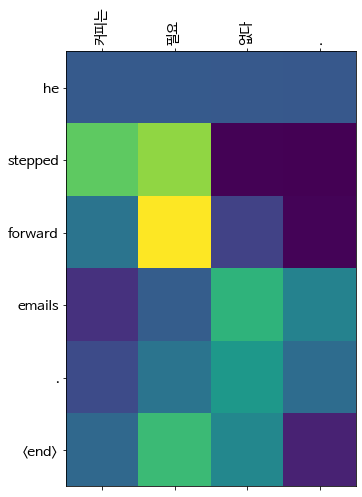

In [90]:
translate('커피는 필요 없다.', encoder, decoder)